To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News


🎉 **News!** Google Colab now has A100 80GB GPUs available. Train massive models faster than ever! We've prepared several notebooks to get you started right away:

* **[gpt-oss 120B](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(120B)_A100-Fine-tuning.ipynb)**

* **[Llama 3.3 70B](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.3_(70B)_A100-Conversational.ipynb)**

* **[Gemma 3 27B](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Gemma3_(27B)_A100-Conversational.ipynb)**

* **[Qwen 3 32B](https://www.kaggle.com/notebooks/welcome?src=https://github.com/unslothai/notebooks/blob/main/nb/Kaggle-Qwen3_(32B)_A100-Reasoning-Conversational.ipynb&accelerator=nvidiaTeslaT4)**

**NEW** Unsloth now supports training the new **gpt-oss** model from OpenAI! You can start finetune gpt-oss for free with our **[Colab notebook](https://x.com/UnslothAI/status/1953896997867729075)**!

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
import torch; torch._dynamo.config.recompile_limit = 64;


### Unsloth

### Launch sglang inference for unsloth/gemma-3n-E2B-it (https://huggingface.co/unsloth/gemma-3n-E2B-it)

In [2]:
# Load and run the model using sglang
!nohup python -m sglang.launch_server --model-path unsloth/gemma-3n-E2B-it --attention-backend fa3 --port 8000 > sglang.log &

# tail vllm logs. Check server has been started correctly
!while ! grep -q "The server is fired up and ready to roll" sglang.log; do tail -n 1 sglang.log; sleep 5; done

nohup: redirecting stderr to stdout
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[2025-07-04 17:48:54] server_args=ServerArgs(model_path='unsloth/gemma-3n-E2B-it', tokenizer_path='unsloth/gemma-3n-E2B-it', tokenizer_mode='auto', skip_tokenizer_init=False, skip_server_warmup=False, load_format='auto', model_loader_extra_config='{}', trust_remote_code=False, dtype='auto', kv_cache_dtype='auto', quantization=None, quantization_param_path=None, context_length=None, device='cuda', served_model_name='unsloth/gemma-3n-E2B-it', chat_template=None, completion_template=None, is_embedding=False, enable_multimodal=None, revision=None, hybrid_kvcache_ratio=None, impl='auto', host='127.0.0.1', port=8000, mem_fraction_static=0.75, max_running_requests=None, max_total_tokens=None, chunked_prefill_size=8192, max_prefill_tokens=16384, schedule_policy='fcfs', schedule_conservativeness=1.0, cpu_offload_gb=0

### Image helper functions

In [3]:
from PIL.ImageFile import ImageFile
from PIL import Image
import numpy as np
import io
import base64
import requests
from io import BytesIO

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def process_image(image: ImageFile) -> str:
    """Process image for sglang gemma3n and return base64 string."""
    assert isinstance(image, ImageFile), "please pass an image object"

    # Resize the image
    resized_image = image.resize((384, 384))

    # Convert to numpy array and transpose
    image_array = np.array(resized_image)
    array_reordered = np.transpose(image_array, (1, 0, 2))

    # Convert back to PIL Image
    processed_image = Image.fromarray(array_reordered)

    # Convert to base64 string
    image_bytes = io.BytesIO()
    processed_image.save(image_bytes, format=image.format)
    base64_image = base64.b64encode(image_bytes.getvalue()).decode("utf-8")


    # Return data URL string
    format_name = image.format.lower() if image.format else 'png'
    return f"data:image/{format_name};base64,{base64_image}"

## Gemma3n Inference using sglang (source model: https://huggingface.co/unsloth/gemma-3n-E2B-it)



## Inference 1
Image source file "https://raw.githubusercontent.com/sgl-project/sglang/refs/heads/main/test/lang/example_image.png"

load image from url source

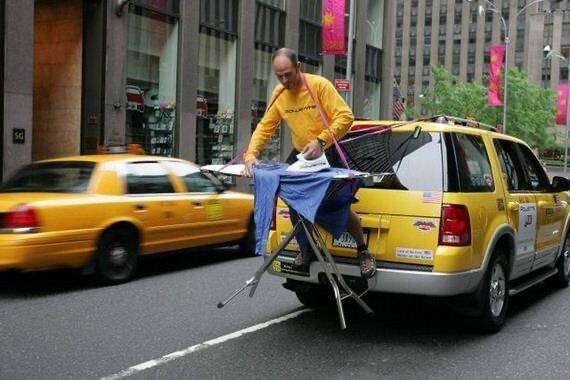

In [4]:
from IPython.display import display
image = load_image_from_url("https://raw.githubusercontent.com/sgl-project/sglang/refs/heads/main/test/lang/example_image.png")
display(image)

Let's run the model!

In [6]:
import requests
from sglang.utils import wait_for_server, print_highlight, terminate_process

processed_image = process_image(image)
url = f"http://localhost:8000/v1/chat/completions"

processed_image = process_image(image)
data = {
    "model": "unsloth/gemma-3n-E2B-it",
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": processed_image
                    },
                },
            ],
        }
    ],
    "max_tokens": 300,
}

response = requests.post(url, json=data)
print_highlight(response.text)

{"id":"4b0ed837363d4f19819b4eeda28f0ebd","object":"chat.completion","created":1751651506,"model":"unsloth/gemma-3n-E2B-it","choices":[{"index":0,"message":{"role":"assistant","content":"The image shows a man ironing a blue shirt on the trunk of a yellow taxi cab in what appears to be a city street. \n\nHere's a breakdown of what's visible:\n\n*   **Man:** An adult male wearing a yellow long-sleeved shirt and dark pants. He is standing on the trunk of the taxi, ironing a blue shirt with an ironing board.\n*   **Taxi:** A yellow taxi cab with a rack on the trunk. The taxi is in motion, as indicated by the motion blur of the background.\n*   **Ironing Board:** A foldable ironing board is set up on the trunk of the taxi, supporting the shirt.\n*   **Shirt:** A blue shirt is being ironed.\n*   **Street:** The taxi is driving on a city street with white lane markings.\n*   **Buildings:** Tall buildings line the street, typical of a city environment.\n*   **Other Vehicles:** Another yellow ta

## Inference 2
Image source file "https://i.ibb.co/1tw5whfz/ocr.png"

load image from url source

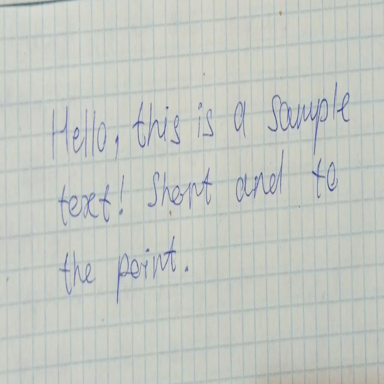

In [7]:
image = load_image_from_url("https://i.ibb.co/1tw5whfz/ocr.png")
display(image)

Let's run the model!

In [8]:
import requests

url = f"http://localhost:8000/v1/chat/completions"
processed_image = process_image(image)
data = {
    "model": "unsloth/gemma-3n-E2B-it",
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Read the text in the image"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": processed_image
                    },
                },
            ],
        }
    ],
    "max_tokens": 300,
}

response = requests.post(url, json=data)
print_highlight(response.text)

{"id":"0d961928e0e542b49ace5d5c1a6c9d7a","object":"chat.completion","created":1751651525,"model":"unsloth/gemma-3n-E2B-it","choices":[{"index":0,"message":{"role":"assistant","content":"Hello, this is a sample text! Short and to the point.","reasoning_content":null,"tool_calls":null},"logprobs":null,"finish_reason":"stop","matched_stop":106}],"usage":{"prompt_tokens":282,"total_tokens":297,"completion_tokens":15,"prompt_tokens_details":null}}


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
